# LSTM Baseline Model Testing

## 0 Imports & Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from utilities import load_complete_time_series, split_data_into_sequences, reconstruct_sequential_data, Scaler, train_test_split, extract_features_and_target
from LSTM import LSTM, train_model
from TimeSeriesDataset import TimeSeriesDataset
from mean_regressor import MeanRegressor

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = True

### Hyperparameters

In [5]:
SEQ_LEN = 15
LEARNING_RATE = 0.001
BATCH_SIZE = 32
HIDDEN_SIZE = 12
NUM_LAYERS = 1

NUM_EPOCHS = 1000

### Features

In [6]:
FEATURES = ['Close', 'Volume']

## 2 Data

### Data Loading

In [7]:
# Load data from csv
# -> convert Date column to datetime
data = load_complete_time_series(f'{REAL_DATA_FOLDER}/AAPL_complete_no_date.csv')
data = data[FEATURES] # remember to put the target column first
data[SEQ_LEN-1:SEQ_LEN+10]

,Close,Volume
14,0.150670,35728000
15,0.143973,45158400
16,0.137835,55686400
17,0.135045,39827200
18,0.142299,21504000
19,0.141183,23699200
20,0.136161,23049600
21,0.136719,14291200
22,0.139509,14067200
23,0.138393,13395200


### Data Preprocessing

In [8]:
data_numpy = data.to_numpy()

In [9]:
data_train, data_test = train_test_split(data_numpy, 0.8)

In [10]:
scaler = Scaler(data_train)

In [11]:
data_train_scaled = scaler.scale_data(data_train)
data_test_scaled = scaler.scale_data(data_test)

In [12]:
data_train_sequences = split_data_into_sequences(data_train_scaled, SEQ_LEN)
data_test_sequences = split_data_into_sequences(data_test_scaled, SEQ_LEN)

Shape of the data after splitting into sequences: (8767, 15, 2)
Shape of the data after splitting into sequences: (2181, 15, 2)


In [13]:
X_train, y_train, X_test, y_test = extract_features_and_target(data_train_sequences, data_test_sequences)

Extracted features and target from training and test data.
Shape of X_train: torch.Size([8767, 14, 2])
Shape of y_train: torch.Size([8767, 1])
Shape of X_test: torch.Size([2181, 14, 2])
Shape of y_test: torch.Size([2181, 1])


In [14]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
# Visualize size of batches
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 14, 2]) torch.Size([32, 1])


## 3 Train Test Loop

In [18]:
# parameters for ['Close']: input_size=1, hidden_size=4, num_stacked_layers=1
model = LSTM(
    device=device,
    input_size=X_train.shape[2], # number of features
    hidden_size=HIDDEN_SIZE,
    num_stacked_layers=NUM_LAYERS
).to(device)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.7, patience=15, threshold=0.001)
criterion = nn.MSELoss()
criterion_absolute = nn.L1Loss()

In [20]:
best_validation_loss, model = train_model(model=model,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    criterion=criterion,
                    optimizer=optimizer,
                    device=device)

Epoch: 1
Validation Loss: 6.144176894956204
**************************************************
Epoch: 2
Validation Loss: 5.8924296003297325
**************************************************
Epoch: 3
Validation Loss: 5.792579579852484
**************************************************
Epoch: 4
Validation Loss: 5.68922761773338
**************************************************
Epoch: 5
Validation Loss: 5.583178846831974
**************************************************
Epoch: 6
Validation Loss: 5.453697999738548
**************************************************
Epoch: 7
Validation Loss: 5.355979258664023
**************************************************
Epoch: 8
Validation Loss: 5.253109841860166
**************************************************
Epoch: 9
Validation Loss: 5.107063278980406
**************************************************
Epoch: 10
Validation Loss: 5.022755233493323
**************************************************
Epoch: 11
Validation Loss: 4.940409782862264
****

## 4 Plot Predictions

### Inverse Transform

In [21]:
with torch.inference_mode(): 
    test_pred = model(X_test.to(device)).to('cpu').detach().numpy()
    train_pred = model(X_train.to(device)).to('cpu').detach().numpy()

In [24]:
test_pred = scaler.inverse_scale_data(test_pred, feature_type='price')
train_pred = scaler.inverse_scale_data(train_pred, feature_type='price')
y_test = scaler.inverse_scale_data(y_test.cpu().numpy(), feature_type='price')
y_train = scaler.inverse_scale_data(y_train.cpu().numpy(), feature_type='price')

In [25]:
loss = criterion_absolute(torch.tensor(test_pred), torch.tensor(y_test)).item()
loss

1971.5993635651212

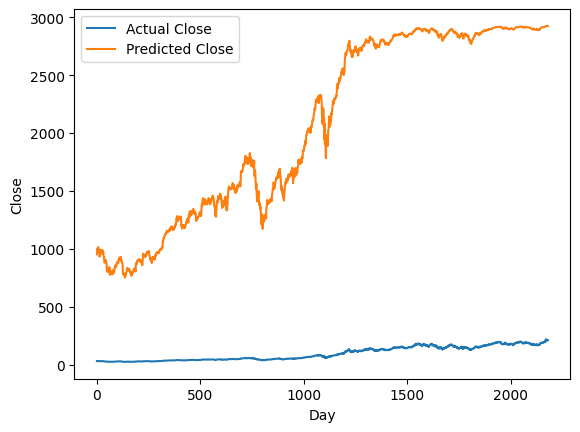

In [26]:
# plot test data
plt.plot(y_test, label="Actual Close")
plt.plot(test_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()


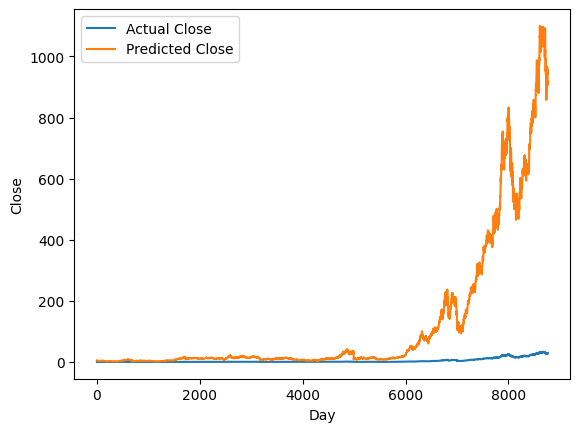

In [27]:
# plot train data
plt.plot(y_train, label="Actual Close")
plt.plot(train_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()


### Dummy Testing

In [23]:
dummy_model = MeanRegressor()
dummy_pred = dummy_model.make_predictions(X_test_unscaled)

In [24]:
dummy_pred.shape

(181,)

In [25]:
loss = criterion_absolute(torch.tensor(dummy_pred), y_test_unscaled).item()
loss

/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([181, 1])) that is different to the input size (torch.Size([181])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


10.306831696095474

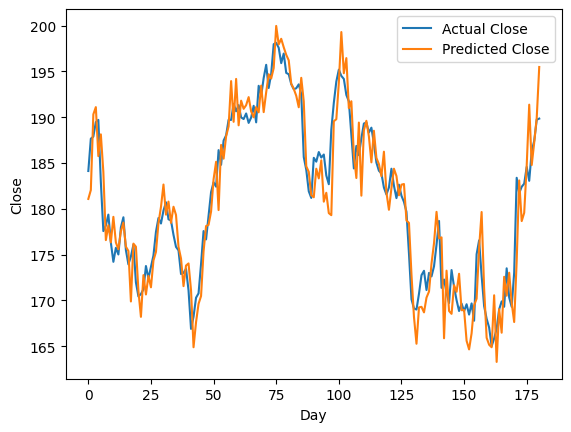

In [26]:
# plot test data
plt.plot(y_test, label="Actual Close")
plt.plot(dummy_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()